In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [3]:
base_dir = '/content/drive/MyDrive/Colab Notebooks'
data_dir = os.path.join(base_dir,'EEG_SHCEEEZ-DL','out')
a_dataset = pathlib.Path(os.path.join(data_dir,'A'))

In [4]:
image_count = len(list(a_dataset.glob('*/*.png')))
print('number of total images:', image_count, '\n\n')

number of total images: 725 




In [5]:
batch_size = 128
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  a_dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  a_dataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 725 files belonging to 2 classes.
Using 580 files for training.
Found 725 files belonging to 2 classes.
Using 145 files for validation.
['norm', 'sch']


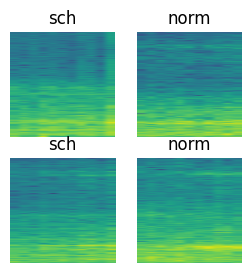

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers


In [11]:
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

chrononet_model = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [12]:
chrononet_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [13]:
chrononet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60
)


Epoch 1/60
5/5 [==============================] - 54s 6s/step - loss: 1.7775 - accuracy: 0.4828 - val_loss: 0.6903 - val_accuracy: 0.5172
Epoch 2/60
5/5 [==============================] - 1s 184ms/step - loss: 0.6999 - accuracy: 0.4966 - val_loss: 0.6919 - val_accuracy: 0.4828
Epoch 3/60
5/5 [==============================] - 1s 184ms/step - loss: 0.6922 - accuracy: 0.5207 - val_loss: 0.6877 - val_accuracy: 0.5172
Epoch 4/60
5/5 [==============================] - 1s 185ms/step - loss: 0.6874 - accuracy: 0.5379 - val_loss: 0.6831 - val_accuracy: 0.7379
Epoch 5/60
5/5 [==============================] - 1s 183ms/step - loss: 0.6821 - accuracy: 0.6397 - val_loss: 0.6709 - val_accuracy: 0.6690
Epoch 6/60
5/5 [==============================] - 1s 203ms/step - loss: 0.6670 - accuracy: 0.6638 - val_loss: 0.6418 - val_accuracy: 0.7724
Epoch 7/60
5/5 [==============================] - 1s 186ms/step - loss: 0.6320 - accuracy: 0.6931 - val_loss: 0.5854 - val_accuracy: 0.7448
Epoch 8/60
5/5 [======

In [14]:
models_path = os.path.join(base_dir, 'EEG_SHCEEEZ-DL', 'models')
chrononet_model.save(os.path.join(models_path, 'chrononet_model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
models_path = os.path.join(base_dir, 'EEG_SHCEEEZ-DL', 'models')
chrononet_model= keras.models.load_model(os.path.join(models_path, 'chrononet_model.h5'))

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


In [18]:
val_pred = chrononet_model.predict(val_ds)
val_true = np.concatenate([y for x, y in val_ds], axis=0)
val_pred = np.argmax(val_pred, axis=-1)


2/2 [==============================] - 0s 72ms/step


In [19]:
def evaluate(model, name='model'):
  loss, acc = model.evaluate(val_ds, batch_size= batch_size)
  print(f"{name}'s accuracy: {round((acc * 100), 2)}%")

evaluate(chrononet_model, 'ChronoNet on STFT')

2/2 [==============================] - 0s 21ms/step - loss: 0.3093 - accuracy: 0.9310
ChronoNet on STFT's accuracy: 93.1%


In [20]:
def predict(model):
  return np.argmax(model.predict(val_ds), axis=-1)

def get_labels(dataset, batch_count=2):
  lst = []
  for im, label in val_ds.take(2):
    lst.extend(label.numpy())
  return np.array(lst)

chrononet_comparison_list = list(zip(predict(chrononet_model), get_labels(val_ds)))
print("chrononet (predictions, true labels): ", chrononet_comparison_list)

2/2 [==============================] - 0s 60ms/step
chrononet (predictions, true labels):  [(0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 0), (0, 0), (1, 1), (0, 1), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 